In [2]:
import pandas as pd

# Ruta del archivo (puedes poner el path completo o solo el nombre si está en la misma carpeta)
ruta_archivo1 = '../Datos/Preprocesados/train.csv.zip'
ruta_archivo2 = '../Datos/Preprocesados/validation.csv.zip'
ruta_archivo3= '../Datos/creditcard.csv.zip'

# Leer el CSV
train = pd.read_csv(ruta_archivo1, compression='zip', )
validation = pd.read_csv(ruta_archivo2, compression='zip', )
originales = pd.read_csv(ruta_archivo3, compression='zip', )

In [3]:
# Imported Libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
#import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib.patches as mpatches
import time

# Classifier Libraries
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import collections


# Other Libraries
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
from collections import Counter
from sklearn.model_selection import KFold, StratifiedKFold
import warnings
warnings.filterwarnings("ignore")

# <span style = 'color: red'>***2.***</span> Análisis descriptivo y exploratorio 

In [4]:
originales['Hour'] = originales['Time'].apply(lambda x: np.floor(x / 3600))

tmp = originales.groupby(['Hour', 'Class'])['Amount'].aggregate(['min', 'max', 'count', 'sum', 'mean', 'median', 'var']).reset_index()
df = pd.DataFrame(tmp)
df.columns = ['Hour', 'Class', 'Min', 'Max', 'Transactions', 'Sum', 'Mean', 'Median', 'Var']
df.head()

,Hour,Class,Min,Max,Transactions,Sum,Mean,Median,Var
0,0.0,0,0.0,7712.43,3961,256572.87,64.774772,12.990,45615.821201
1,0.0,1,0.0,529.00,2,529.00,264.500000,264.500,139920.500000
2,1.0,0,0.0,1769.69,2215,145806.76,65.826980,22.820,20053.615770
3,1.0,1,59.0,239.93,2,298.93,149.465000,149.465,16367.832450
4,2.0,0,0.0,4002.88,1555,106989.39,68.803466,17.900,45355.430437


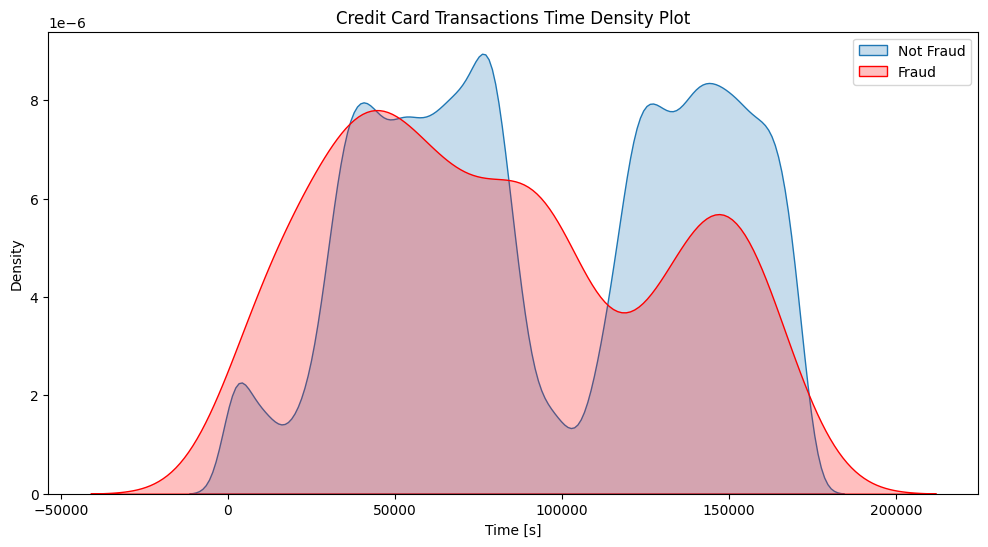

In [5]:

class_0 = originales.loc[originales['Class'] == 0]["Time"]
class_1 = originales.loc[originales['Class'] == 1]["Time"]

plt.figure(figsize=(12,6))
sns.kdeplot(class_0, label='Not Fraud', fill=True)
sns.kdeplot(class_1, label='Fraud', fill=True, color='red')
plt.title('Credit Card Transactions Time Density Plot')
plt.xlabel('Time [s]')
plt.legend()
plt.show()

Eje X: Time [s] — El tiempo (en segundos) desde el inicio de la recopilación de datos.

Eje Y: Density — Densidad (probabilidad relativa de ocurrencia en cada rango de tiempo).

Curva azul: Transacciones no fraudulentas (Not Fraud)

Curva roja: Transacciones fraudulentas (Fraud)

### ***Interpretación***
Patrones de comportamiento diferentes:
Las distribuciones para fraude y no fraude no son idénticas. Hay momentos del día (o de la ventana de muestreo) en que el fraude es relativamente más frecuente que el resto del tiempo.

- Las picos muestran horas en las que hay más transacciones.

- El fraude ocurre con más frecuencia relativa en ciertos periodos. Indicando que el riesgo de fraude es más alto en esos momentos.

- También se observa que las curvas coinciden, la probabilidad de fraude es similar a la de una transacción común en ese periodo.

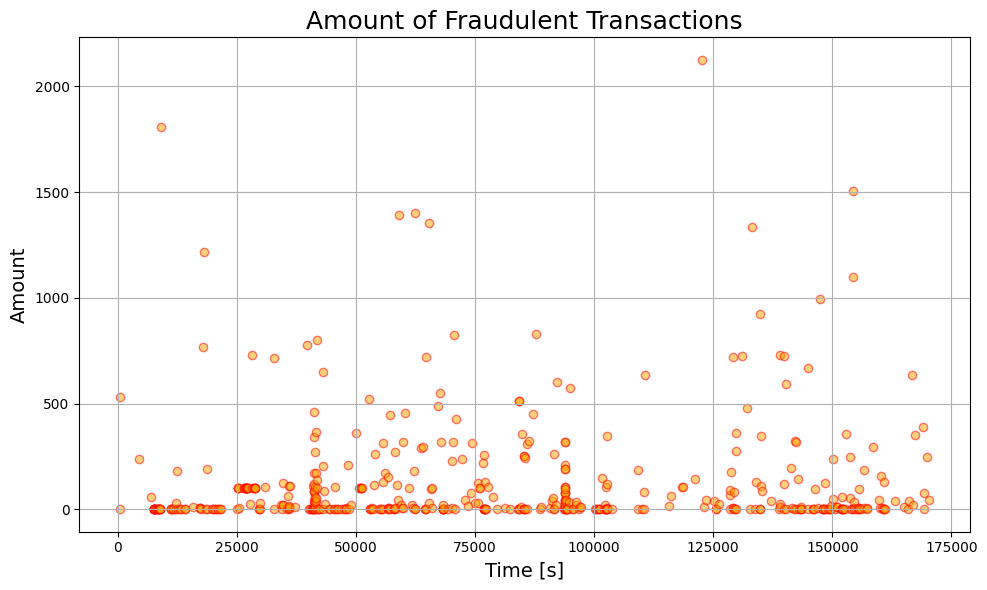

In [6]:
fraud = originales[originales['Class'] == 1]

# Asumiendo que 'fraud' ya está definido como originales[originales['Class'] == 1]

plt.figure(figsize=(10,6))
plt.scatter(fraud['Time'], fraud['Amount'], 
            color='orange', edgecolor='red', alpha=0.5)

plt.title('Amount of Fraudulent Transactions', fontsize=18)
plt.xlabel('Time [s]', fontsize=14)
plt.ylabel('Amount', fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.show()


X: Time [s] (segundos desde el inicio del registro de transacciones)

Y: Amount (valor monetario de cada transacción)

Puntos: Cada punto es una transacción que corresponde a transacciones fraudulentas.

### ***Conclusiones***
- No hay una tendencia clara en el tiempo

- Los fraudes ocurren a lo largo de todo el rango de tiempo, no están concentrados en una ventana específica del día.

- No se observan concentraciones temporales donde el fraude sea más intenso.

- La mayoría de los fraudes involucran montos pequeños

-  mayor concentración de puntos está cerca de valores bajos de Amount (menores a 500).

La mayoría de las transacciones fraudulentas involucran montos pequeños, lo cual es consistente con patrones típicos de fraude (para evadir detección).

Existen fraudes de montos altos, pero son menos frecuentes

Hay algunos outliers (puntos aislados arriba de 1000, incluso cerca de 2000 o más).

Conclusión: Aunque poco frecuentes, existen intentos de fraude con montos significativamente altos.


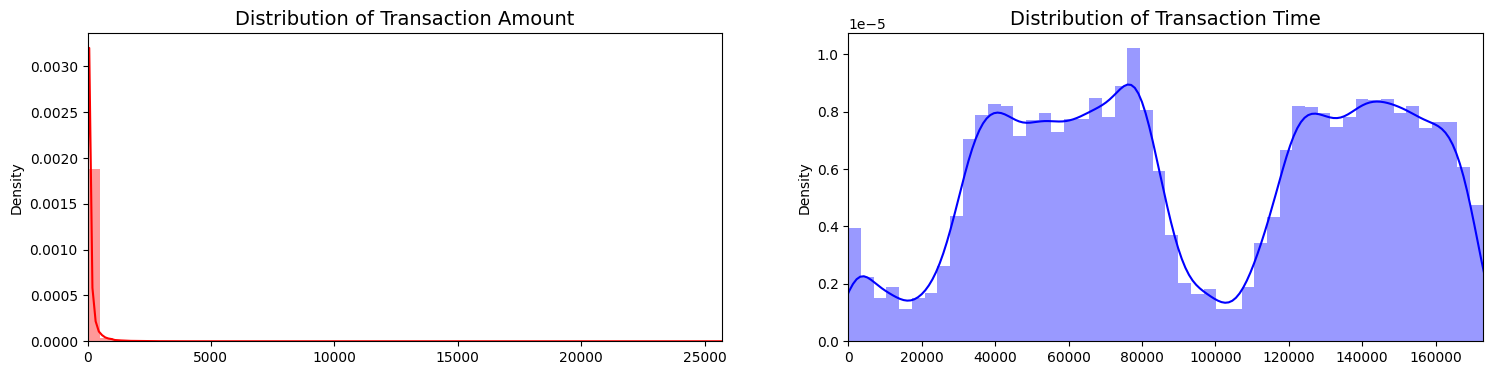

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(18,4))

amount_val = originales['Amount'].values
time_val = originales['Time'].values

sns.distplot(amount_val, ax=ax[0], color='r')
ax[0].set_title('Distribution of Transaction Amount', fontsize=14)
ax[0].set_xlim([min(amount_val), max(amount_val)])

sns.distplot(time_val, ax=ax[1], color='b')
ax[1].set_title('Distribution of Transaction Time', fontsize=14)
ax[1].set_xlim([min(time_val), max(time_val)])



plt.show()

#### Izquierda: Distribution of Transaction Amount
- La gran mayoría de las transacciones tienen un monto bajo.

- La curva es extremadamente alta cerca de 0 y cae rápidamente.

Conclusión: El grueso de las transacciones (fraudulentas o no, según la base mostrada) corresponde a montos pequeños, por debajo de 500 o incluso menos.

- Hay pocos valores altos (outliers).

- El eje X llega hasta 25,000, pero la densidad ahí es prácticamente cero.

Conclusión: Las transacciones de gran valor son muy raras y atípicas. Esto es típico en bases reales: muchas transacciones pequeñas, pocas muy grandes.

#### Derecha: Distribution of Transaction Time
- La distribución del tiempo no es uniforme.

- Se observan dos “picos” principales y una caída clara al centro, en torno a 90,000-100,000.

Conclusión: Hay dos intervalos de tiempo en el día (o ciclo de registro) donde ocurren más transacciones; podría deberse a horarios pico (por ejemplo, en la mañana y la tarde), y una baja actividad en la mitad del ciclo (probablemente en la madrugada).

- No hay evidencia de concentración extrema en un solo periodo.

- Aunque hay picos, la actividad es significativa en varios momentos, no solo en un horario.

Conclusión: No hay “ventanas únicas” para la actividad transaccional, pero sí hay horarios preferidos.

### ***Conclusión general***

La mayoría de las transacciones son de bajo monto, con muy pocos eventos de alto valor. En cuanto al tiempo, la actividad no está distribuida uniformemente, sino que existen al menos dos periodos bien definidos de mayor transacción, probablemente asociados a los horarios de mayor actividad del comercio o la banca. Estos patrones son importantes para ajustar reglas de monitoreo de fraude, establecer umbrales de alerta por horario y entender el comportamiento típico del sistema.

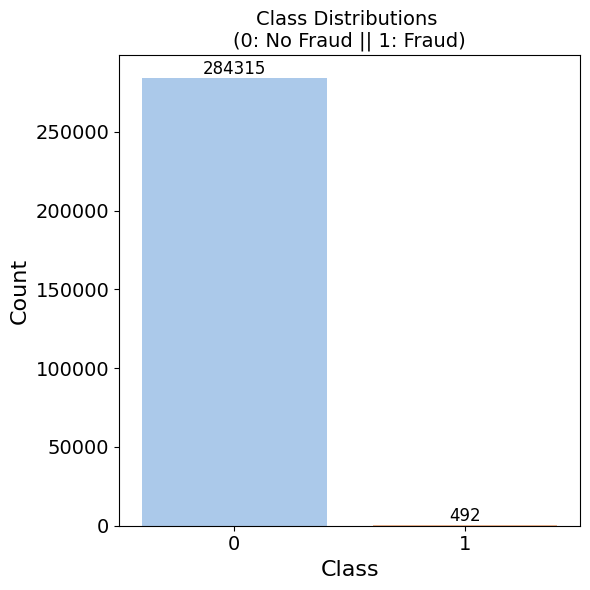

In [38]:
plt.figure(figsize=(6, 6))  # Cambia los valores para más ancho y alto
ax = sns.countplot(x='Class', data=originales, palette="pastel")
plt.title('Class Distributions \n(0: No Fraud || 1: Fraud)', fontsize=14)

# Etiquetas encima de las barras
for p in ax.patches:
    count = int(p.get_height())
    ax.annotate(f'{count}', 
                (p.get_x() + p.get_width() / 2, p.get_height()), 
                ha='center', va='bottom', fontsize=12, color='black')

plt.xlabel('Class', fontsize=16)
plt.ylabel('Count', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()  # Para que no se corte nada
plt.show()


#### Preparación modelo

Distribution of the Classes in the subsample dataset
class
0    0.5
1    0.5
Name: count, dtype: float64


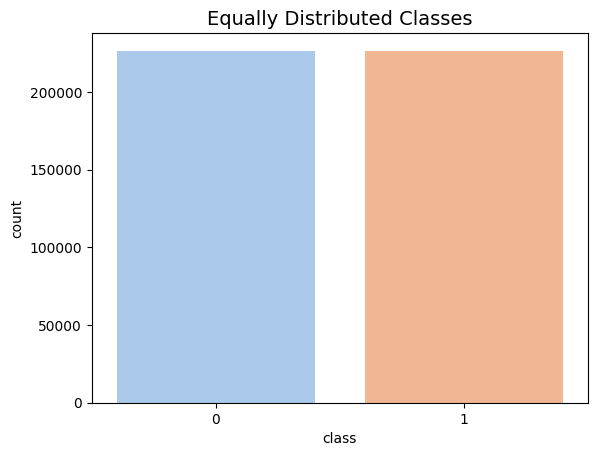

In [8]:

print('Distribution of the Classes in the subsample dataset')
print(train['class'].value_counts()/len(train))



sns.countplot(x='class', data=train, palette="pastel")
plt.title('Equally Distributed Classes', fontsize=14)
plt.show()
